# 1. Initial boundary value problem

The equation with Dirichlet boundary and initial conditions can be written in the form:
\begin{equation}
    \begin{cases}
        u_t = u_{xx} + 2u_x + 3u + t^2(x-1) \text{ where $x \in (0,L)$}\\
        u(t=0,x) = 4\sin(2\pi x)\\
        u(t, x=0) = -8t + \sin(8\pi t)\\
        \frac{\partial u}{\partial t}(t, x=L) = 10t+8\pi
    \end{cases}
    \tag{1}
\end{equation}


Text(0.5, 0, 'u')

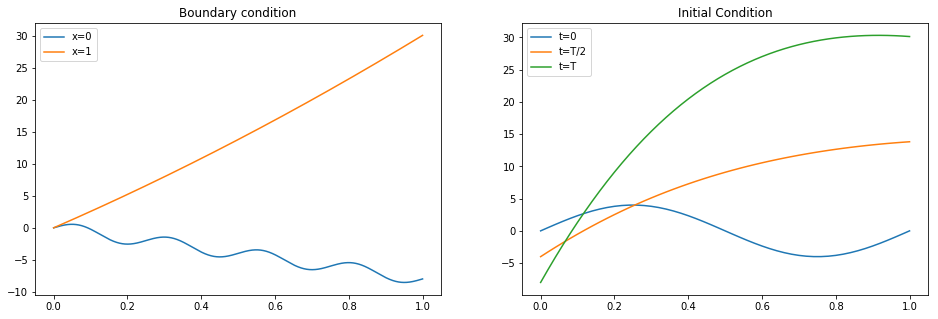

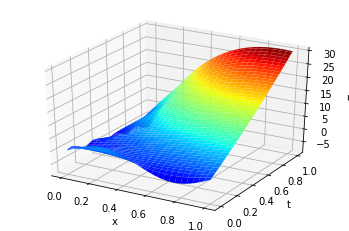

In [259]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

def prob1(T,L,N,I):
    import numpy as np
    from math import sin
    
    x = np.linspace(0,L,I+1)
    t = np.linspace(0,T,N+1)

    dx = L/I
    dt = T/N
    
    u = np.zeros((N+1, I+1))
    
    def IC(x):
        return 4*sin(2*np.pi*x)
    def BC_0(t):
        return -8*t+sin(8*np.pi*t)
    def BC_1(t):
        return 10*t+8*np.pi
    
    for i in range(0,I+1):
        u[0,i]=IC(x[i])

    for n in range(0,N+1):
        u[n,0]=BC_0(t[n])

    for n in range(0,N):
        for i in range(1,I):
            u[n+1,i]=u[n,i]+dt*((u[n,i+1]+u[n,i-1]-2*u[n,i])/dx**2+(u[n,i+1]-u[n,i-1])/dx+3*u[n,i]+t[n]**2*(x[i]-1))
            
        u[n+1,I]=u[n,I]+dt*BC_1(t[n])
        
    return t,x,u
        
        
t,x,u = prob1(1,1,5000,50)

plt.subplots(figsize = (16,5))

plt.subplot(1,2,1)
plt.plot(t,u[:,0], t, u[:, -1])
plt.legend(['x=0', 'x=1'])
plt.title('Boundary condition')

plt.subplot(1,2,2)
plt.plot(x, u[0, :], x, u[2500,:], x, u[-1, :])
plt.legend(['t=0', 't=T/2', 't=T'])
plt.title('Time Condition')


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(x, (len(t),1))
                , np.tile(t.transpose(), (len(x),1)).transpose()
                , u, cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

# 2. Binary Put option

The B-S equation with Dirichlet boundary condition

\begin{equation}
    \begin{cases}
        V_t - rV + rSV_s + \frac{1}{2}\sigma^2S^2 V_{xx} =0\\
        V(t=T,S) = SH(K-S)\\
        V(t, S=0) = 0\\
        V(t, S=L) = 0
    \end{cases}
    \tag{2}
\end{equation}

where $H(x)$ is the Heviside function

\begin{equation}
    H(x) = 
    \begin{cases}
         1 \text{ if $x \geq 0$}\\
         0 \text{ if $x < 0$}
    \end{cases}
    \tag{3}
\end{equation}

In [300]:
class Put:
    import numpy as np
    
    def __init__(self, K, T, L, N, I, sigma, r):
        self.K = K
        self.T = T
        self.L = L
        self.N = N
        self.I = I
        self.sigma = sigma
        self.r = r
        
    def price(self, type):
        S = np.linspace(0, self.L, self.I+1)
        t = np.linspace(0, self.T, self.N+1)

        dt = self.T/self.N
        dS = self.L/self.I

        V = np.zeros((self.N+1, self.I+1))

        def TC(S,K):
            if K-S>=0:
                return S
            else:
                return 0
        
        for i in range(0,self.I+1):
            V[N,i] = TC(S[i],self.K)
        
        if type == 'dirichlet':

            for n in range(0,self.N+1):
                V[n,0] = 0
                V[n,self.I] = 0

            for n in range(self.N,0,-1):
                for i in range(1,self.I):
                    V[n-1,i]=V[n,i]+dt*self.r*S[i]/(2*dS)*(V[n,i+1]-V[n,i-1])+0.5*(self.sigma**2)*(S[i]**2)*dt/(dS**2)*(V[n,i+1]+V[n,i-1]-2*V[n,i])-self.r*dt*V[n,i]

            return t,S,V
        else:

            for n in range(self.N,0,-1):
                for i in range(1,self.I):
                    V[n-1,i]=V[n,i]+dt*self.r*S[i]/(2*dS)*(V[n,i+1]-V[n,i-1])+0.5*(self.sigma**2)*(S[i]**2)*dt/(dS**2)*(V[n,i+1]+V[n,i-1]-2*V[n,i])-self.r*dt*V[n,i]
                
                V[n-1,0]=V[n-1,1]-dS*1
                V[n-1,self.I]=V[n-1,self.I-1]+dS*0
                
            return t,S,V

    def delta(self):
        
        dS = self.L/self.I
        dt = self.T/self.N
        
        t,S,V = self.price('newmann')
        f = np.zeros((self.N+1, self.I+1))
        
        for n in range(0,self.N+1):
            for i in range(0,self.I):
                f[n,i]=(V[n,i+1] - V[n,i-1])/(2*dS)
                
            f[n,0] = 1
            f[n,self.I] = 0
        
        return t,S,f
        
    def gamma(self):
        
        dS = self.L/self.I
        
        t,S,V = self.price('newmann')
        f = np.zeros((self.N+1, self.I+1))
        
        for n in range(0,self.N+1):
            for i in range(1,self.I):
                f[n,i]=(V[n,i+1] + V[n,i-1] - 2*V[n,i])/(dS**2)
                
            f[n,0] = 0
            f[n,self.I] = 0
        
        return t,S,f 
        
    def theta(self):
        
        dt = self.T/self.N
        
        t,S,V = self.price('newmann')
        f = np.zeros((self.N+1, self.I+1))
        
        for i in range(1,self.I):
            for n in range(0,self.N):
                f[n,i]=(V[n+1,i] - V[n-1,i])/(2*dt)
                
            f[0,i] = f[1,i]
            f[self.N,i] = f[self.N,i]
        
        return t,S,f 
        
        
put = Put(10, 0.5, 30, 5000, 100, 0.5, 0.1)      
t,x,u = put.price('dirichlet')
t,x,delta = put.delta()
t,x,gamma = put.gamma()
t,x,theta = put.theta()


Text(0.5, 0, 'theta')

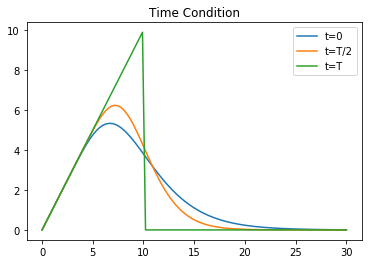

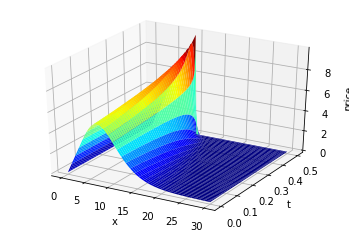

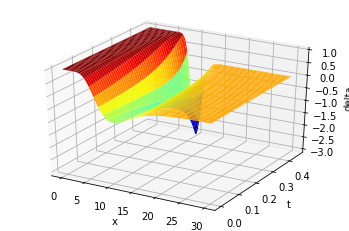

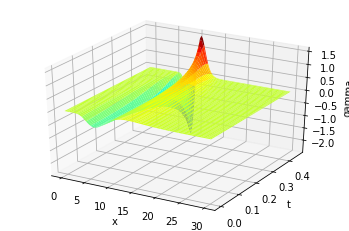

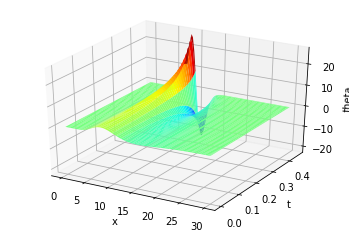

In [301]:
plt.plot(x, u[0, :], x, u[2500,:], x, u[-1, :])
plt.legend(['t=0', 't=T/2', 't=T'])
plt.title('Time Condition')


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(x, (len(t),1))
                , np.tile(t.transpose(), (len(x),1)).transpose()
                , u, cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('price')

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(x, (4501,1))
                , np.tile(t[0:4501].transpose(), (len(x),1)).transpose()
                , delta[0:4501,:], cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('delta')

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(x, (4501,1))
                , np.tile(t[0:4501].transpose(), (len(x),1)).transpose()
                , gamma[0:4501,:], cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('gamma')

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(x, (4501,1))
                , np.tile(t[0:4501].transpose(), (len(x),1)).transpose()
                , theta[0:4501,:], cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('theta')

# 3. Hyperbolic equation for wave packet

\begin{equation}
    \begin{cases}
        u_{tt} = u_{xx}\\
        u(t=0,x) = Ae^{-\frac{(x-x_0)^2}{2\sigma^2}}\cos(q(x-x_0))\\
        u_t(t=0,x) = v(x)
    \end{cases}
    \tag{3}
\end{equation}

for

$$v(x)=0$$

Text(0.5, 0, 'u')

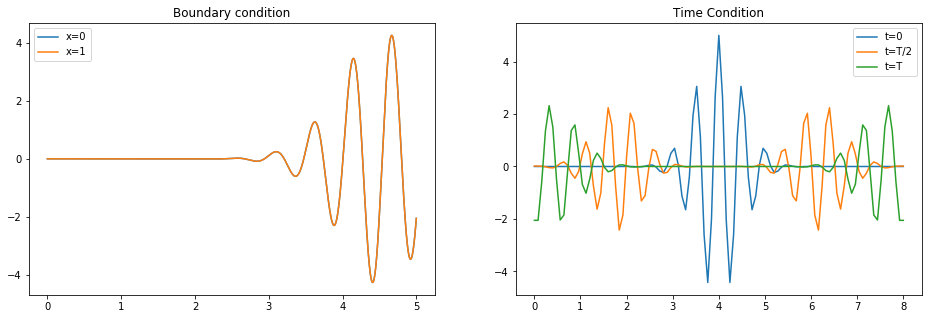

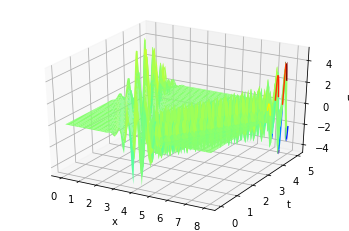

In [313]:
def wave(T,L,N,I,a,A,x0,sigma,q):
    import numpy as np
    from math import cos
    
    x = np.linspace(0,L,I+1)
    t = np.linspace(0,T,N+1)

    dx = L/I
    dt = T/N
    def IC(x,x0,A,sigma,q):
        return A*np.exp(-(x-x0)**2/(2*sigma**2))*cos(q*(x-x0))
        
    def IV(x,x0,A,sigma,q):
        return A*np.exp(-(x-x0)**2/(2*sigma**2))*((x-x0)**2/sigma**2*cos(q*(x-x0))*cos(q/2)+2*sin(q*(x-x0))*sin(q/2))
        
    for i in range(0,I+1):
        u[0,i] = IC(x[i],x0,A,sigma,q)
        u[1,i] = u[0,i] + dt*IV(x[i],x0,A,sigma,q)

    for n in range(1,N):
        for i in range(1,I):
            u[n+1,i] = -u[n-1,i]+2*u[n,i]+a**2*(dt/dx)**2*(u[n,i+1]+u[n,i-1]-2*u[n,i])
            
        u[n+1,I]=u[n+1,1]
        u[n+1,0]=u[n+1,I]
        
    return t,x,u

t,x,u = wave(5,8,5000,100,1,5,4,0.5,4*np.pi)

plt.subplots(figsize = (16,5))

plt.subplot(1,2,1)
plt.plot(t,u[:,0], t, u[:, -1])
plt.legend(['x=0', 'x=1'])
plt.title('Boundary condition')

plt.subplot(1,2,2)
plt.plot(x, u[0, :], x, u[2500,:], x, u[-1, :])
plt.legend(['t=0', 't=T/2', 't=T'])
plt.title('Time Condition')


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(x, (len(t),1))
                , np.tile(t.transpose(), (len(x),1)).transpose()
                , u, cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

# 4. Dupire equation


\begin{equation}
    \begin{cases}
        V_T + rKV_K - \frac{1}{2}\sigma_{local}^2(K,T)K^2 V_{KK} =0\\
        V(t=0,K) = \max(S_0-K, 0)\\
        V(t, S=0) = 0\\
        V(t, S=L) = 0
    \end{cases}
    \tag{4}
\end{equation}

where 

\begin{equation}
    \sigma_{local}(K,T) = \frac{\cos(\pi T)}{K/S_0 +1}
\end{equation}

Text(0.5, 0, 'vol')

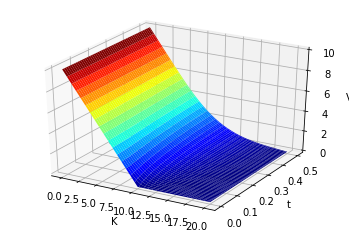

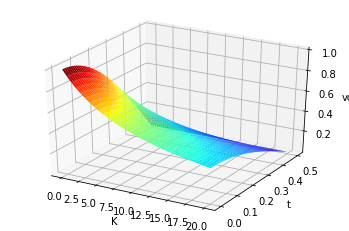

In [317]:
def Dupire(S0,T,L,N,I,r):
    import numpy as np
    from math import cos
    
    K = np.linspace(0,L,I+1)
    t = np.linspace(0,T,N+1)

    dt=T/N
    dK=L/I
    
    def sigma(K,S0,t):
        return cos(np.pi*t)/(K/S0+1)
    
    def IC(S,K):
        return max(S-K,0)
    
    V = np.zeros((N+1, I+1))
    vol = np.zeros((N+1, I+1))
    
    for n in range(0,N+1):
        V[n,0] = S0
        V[n,I] = 0

    for i in range(0,I+1):
        V[0,i] = IC(S0,K[i])

    for n in range(0,N):
        for i in range(0,I):
            V[n+1,i]=V[n,i]-dt*(r*K[i]*(V[n,i+1]-V[n,i-1])/(2*dK)-0.5*sigma(K[i],S0,t[n])*(K[i]**2)*(V[n,i+1]+V[n,i-1]-2*V[n,i])/(dK**2))

    for n in range(0,N+1):
        for i in range(0,I+1):
            vol[n,i]=sigma(K[i],S0,t[n])
            
    return t,K,vol,V

t,K,vol,V = Dupire(10,0.5,20,5000,100,0.1)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(K, (len(t),1))
                , np.tile(t.transpose(), (len(K),1)).transpose()
                , V, cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('K')
ax.set_ylabel('t')
ax.set_zlabel('V')

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(np.tile(K, (len(t),1))
                , np.tile(t.transpose(), (len(K),1)).transpose()
                , vol, cmap=plt.cm.jet, linewidth=0)
ax.set_xlabel('K')
ax.set_ylabel('t')
ax.set_zlabel('vol')